In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import joblib


In [ ]:

years = [2017, 2018, 2019, 2020, 2021]
dfs = [pd.read_csv(f'cleaned_data_{year}.csv') for year in years]
df = pd.concat(dfs, ignore_index=True)

new_df = df.drop(columns=['height'], axis=1)

new_df



,target,GC,Age,Length,weight,One day races,GC_specialty,Time trial,Sprint,Climber,PCS Ranking,UCI World Ranking,Specials | All Time Ranking,sumres_1,sumres_2,sumres_3,Stage_Type_RR
0,1,1.0,22.0,118.5,69.0,297.0,1214.0,1221.0,511.0,500.0,775.0,565.0,1142.0,500.00,123.0,33.0,1.0
1,1,2.0,23.0,118.5,82.0,98.0,612.0,70.0,21.0,460.0,299.0,491.0,985.0,160.00,177.0,77.0,1.0
2,1,3.0,26.0,118.5,73.0,350.0,411.0,1.0,262.0,248.0,473.0,1873.0,985.0,67.00,46.0,52.0,1.0
3,1,8.0,28.0,118.5,68.6,861.5,856.0,417.5,900.0,779.0,520.0,861.0,985.0,32.00,107.7,5.0,1.0
4,1,9.0,23.0,118.5,72.0,861.5,856.0,417.5,900.0,779.0,520.0,861.0,985.0,186.00,212.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120256,0,75.9,37.0,239.0,70.0,135.0,110.0,377.0,319.0,74.0,765.0,1878.0,1003.0,0.00,34.0,15.0,1.0
120257,0,75.9,32.0,239.0,73.0,4046.0,3550.0,2954.0,8068.0,1614.0,508.0,698.0,86.0,5.00,51.0,81.0,1.0
120258,0,75.9,23.0,239.0,67.9,813.5,862.0,386.2,880.0,791.5,547.5,847.0,1003.0,85.25,134.9,141.2,1.0
120259,0,75.9,25.0,239.0,61.0,594.0,371.0,79.0,256.0,561.0,39.0,27.0,1003.0,60.00,3.0,0.0,1.0


In [ ]:
def train_val_test_split(df, rstate=42, shuffle=False, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.3, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    test_set, val_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [ ]:
!pip install tensorflow

In [ ]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)


In [ ]:
train_set, val_set, test_set = train_val_test_split(new_df, stratify='target')
X_train, y_train = remove_labels(train_set, 'target')
X_val, y_val = remove_labels(val_set, 'target')
X_test, y_test = remove_labels(test_set, 'target')

In [ ]:
# Baseline ANN model with two hidden layers (64, 32) using ReLU and Sigmoid activations.
# Compiled with Binary Crossentropy and Adam optimizer to perform binary classification.
# Class weights are applied to handle data imbalance and EarlyStopping prevents overfitting.
# Feature names are saved for reproducibility, and the trained model is stored for evaluation.

import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)


model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])

class_weights = class_weight.compute_class_weight(
    'balanced' , classes=np.unique(y_train), y=y_train
)

class_weights = dict(enumerate(class_weights))


es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

feature_names = list(X_train.columns)
joblib.dump(feature_names, f'features_model1.pkl')

history_1 = model1.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                     class_weight=class_weights,
                     callbacks=[es])
model1.save('model1.h5')

Epoch 1/10
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6174 - auc: 0.6392 - loss: 9.6428 - precision: 0.2970 - recall: 0.6171 - val_accuracy: 0.4288 - val_auc: 0.7043 - val_loss: 3.4447 - val_precision: 0.2486 - val_recall: 0.8827
Epoch 2/10
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6628 - auc: 0.7054 - loss: 1.6835 - precision: 0.3393 - recall: 0.6664 - val_accuracy: 0.5077 - val_auc: 0.7583 - val_loss: 1.5600 - val_precision: 0.2812 - val_recall: 0.8997
Epoch 3/10
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.6773 - auc: 0.7245 - loss: 0.9575 - precision: 0.3538 - recall: 0.6797 - val_accuracy: 0.7142 - val_auc: 0.7726 - val_loss: 0.6418 - val_precision: 0.3922 - val_recall: 0.7157
Epoch 4/10
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7033 - auc: 0.7532 - loss: 0.6876 - precision: 0.3814 - recall: 0.7014 - val_accuracy: 0.7132 - val_auc: 0.7862 - val_loss: 0.5958 - val_precision: 0.3941 - val_recall: 0.7405
Epoch 5/10
2631/2631 ━

<Axes: >

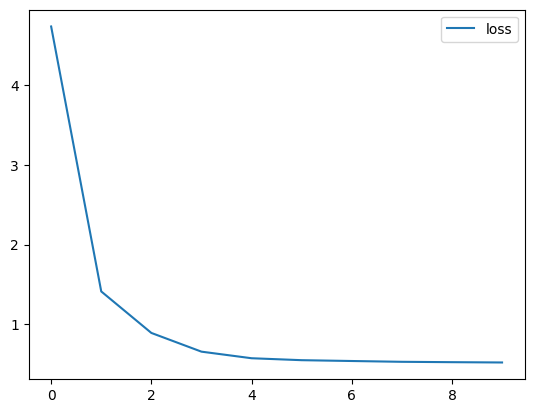

In [ ]:
import pandas as pd
pd.DataFrame(history_1.history)[["loss"]].plot()

<Axes: >

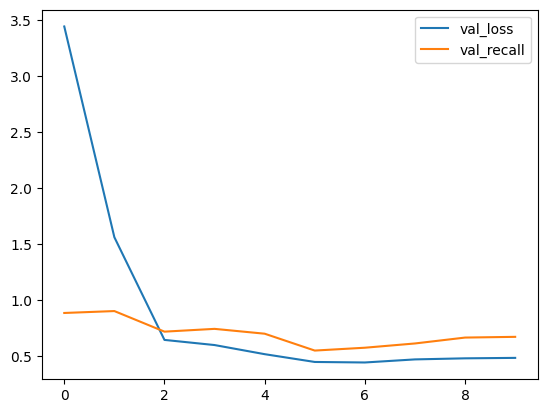

In [ ]:
pd.DataFrame(history_1.history)[["val_loss","val_recall"]].plot()

In [ ]:
# Model 2: ANN with dropout and RobustScaler preprocessing.
# RobustScaler is applied to reduce the influence of outliers before training.
# Added a 0.3 dropout rate for regularization and used class weights to handle imbalance.
# EarlyStopping prevents overfitting (patience=5), and the model is saved for comparison.


In [ ]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)sa
X_test = scaler.transform(X_test)

In [ ]:
train_set, val_set, test_set = train_val_test_split(new_df, stratify='target')
X_train, y_train = remove_labels(train_set, 'target')
X_val, y_val = remove_labels(val_set, 'target')
X_test, y_test = remove_labels(test_set, 'target')

In [ ]:
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)


model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])

class_weights = class_weight.compute_class_weight(
    'balanced' , classes=np.unique(y_train), y=y_train
)

class_weights = dict(enumerate(class_weights))


es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

feature_names = list(X_train.columns)
joblib.dump(feature_names, f'features_model2.pkl')

history_2 = model2.fit(X_train, y_train, epochs=15,
                    validation_data=(X_val, y_val),
                     class_weight=class_weights,
                     callbacks=[es])

model2.save('model2.h5')

Epoch 1/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5522 - auc_1: 0.5552 - loss: 24.2850 - precision_1: 0.2427 - recall_1: 0.5498 - val_accuracy: 0.7432 - val_auc_1: 0.5978 - val_loss: 0.8776 - val_precision_1: 0.3623 - val_recall_1: 0.3316
Epoch 2/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.6072 - auc_1: 0.5890 - loss: 1.0581 - precision_1: 0.2659 - recall_1: 0.5048 - val_accuracy: 0.7366 - val_auc_1: 0.6552 - val_loss: 0.6729 - val_precision_1: 0.3829 - val_recall_1: 0.4646
Epoch 3/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7458 - auc_1: 0.6681 - loss: 0.6688 - precision_1: 0.4015 - recall_1: 0.4688 - val_accuracy: 0.8123 - val_auc_1: 0.7422 - val_loss: 0.5730 - val_precision_1: 0.5459 - val_recall_1: 0.5051
Epoch 4/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7720 - auc_1: 0.7205 - loss: 0.6024 - precision_1: 0.4576 - recall_1: 0.5501 - val_accuracy: 0.7748 - val_auc_1: 0.7871 - val_loss: 0.5492 - val_precision_1: 0.4

In [ ]:
# Model 3: Same ANN architecture as Model 2 but with a higher learning rate (0.01).
# The goal is to test faster convergence and its effect on performance and stability.
# Class weights and EarlyStopping are kept to manage imbalance and prevent overfitting.

In [ ]:
train_set, val_set, test_set = train_val_test_split(new_df, stratify='target')
X_train, y_train = remove_labels(train_set, 'target')
X_val, y_val = remove_labels(val_set, 'target')
X_test, y_test = remove_labels(test_set, 'target')

In [ ]:
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)


model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
               metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])

class_weights = class_weight.compute_class_weight(
    'balanced' , classes=np.unique(y_train), y=y_train
)

class_weights = dict(enumerate(class_weights))


es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

feature_names = list(X_train.columns)
joblib.dump(feature_names, f'features_model3.pkl')

history_3 = model3.fit(X_train, y_train, epochs=15,
                    validation_data=(X_val, y_val),
                     class_weight=class_weights,
                     callbacks=[es])

model3.save('model3.h5')

Epoch 1/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5388 - auc_2: 0.5155 - loss: 6.4255 - precision_2: 0.2142 - recall_2: 0.4628 - val_accuracy: 0.7949 - val_auc_2: 0.5000 - val_loss: 0.6913 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4598 - auc_2: 0.4998 - loss: 0.7022 - precision_2: 0.2050 - recall_2: 0.5692 - val_accuracy: 0.7949 - val_auc_2: 0.5000 - val_loss: 0.6924 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4564 - auc_2: 0.4996 - loss: 0.6976 - precision_2: 0.2050 - recall_2: 0.5759 - val_accuracy: 0.7949 - val_auc_2: 0.5000 - val_loss: 0.6921 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4693 - auc_2: 0.4995 - loss: 0.6996 - precision_2: 0.2049 - recall_2: 0.5533 - val_accuracy: 0.7949 - val_auc_2: 0.5000 - val_loss: 0.6922 

<Axes: >

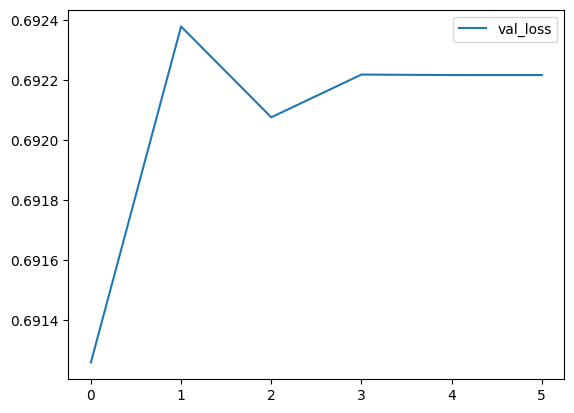

In [ ]:
pd.DataFrame(history_3.history)[["val_loss"]].plot()

In [ ]:
# Model 4: ANN using MinMaxScaler for normalization and a lower learning rate (0.001).
# MinMaxScaler standardizes all features to [0,1], improving training stability.
# Class weights are applied to address imbalance, and EarlyStopping avoids overfitting.

In [ ]:
train_set, val_set, test_set = train_val_test_split(new_df, stratify='target')
X_train, y_train = remove_labels(train_set, 'target')
X_val, y_val = remove_labels(val_set, 'target')
X_test, y_test = remove_labels(test_set, 'target')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# We want to recover the dataframe to extract the features columns names easier.
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)


model4 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])

class_weights = class_weight.compute_class_weight(
    'balanced' , classes=np.unique(y_train), y=y_train
)

class_weights = dict(enumerate(class_weights))


es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
feature_names = list(X_train.columns)
joblib.dump(feature_names, f'features_model4.pkl')

history_4 = model4.fit(X_train, y_train, epochs=15,
                    validation_data=(X_val, y_val),
                     class_weight=class_weights,
                     callbacks=[es])

model4.save('model4.h5')

Epoch 1/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6879 - auc_3: 0.7572 - loss: 0.5877 - precision_3: 0.3749 - recall_3: 0.7019 - val_accuracy: 0.8018 - val_auc_3: 0.8183 - val_loss: 0.4627 - val_precision_3: 0.5132 - val_recall_3: 0.6532
Epoch 2/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7732 - auc_3: 0.8231 - loss: 0.5159 - precision_3: 0.4678 - recall_3: 0.7130 - val_accuracy: 0.8057 - val_auc_3: 0.8245 - val_loss: 0.4634 - val_precision_3: 0.5210 - val_recall_3: 0.6538
Epoch 3/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7845 - auc_3: 0.8282 - loss: 0.5084 - precision_3: 0.4851 - recall_3: 0.7059 - val_accuracy: 0.8044 - val_auc_3: 0.8275 - val_loss: 0.4689 - val_precision_3: 0.5181 - val_recall_3: 0.6627
Epoch 4/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7896 - auc_3: 0.8311 - loss: 0.5047 - precision_3: 0.4934 - recall_3: 0.7035 - val_accuracy: 0.8055 - val_auc_3: 0.8300 - val_loss: 0.4674 - val_precision_3: 0.520

In [ ]:
# Evaluate Model 4 across different decision thresholds (0.3–0.5)
# to find which cutoff gives the best F1-score balance between precision and recall.

In [ ]:
for t in [0.3, 0.4, 0.5]:
    y_pred = (model4.predict(X_val) > t).astype(int)
    print(f"Threshold={t}: F1={f1_score(y_val, y_pred):.3f}")


564/564 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Threshold=0.3: F1=0.516
564/564 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step
Threshold=0.4: F1=0.564
564/564 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Threshold=0.5: F1=0.596


In [ ]:
train_set, val_set, test_set = train_val_test_split(new_df, stratify='target')
X_train, y_train = remove_labels(train_set, 'target')
X_val, y_val = remove_labels(val_set, 'target')
X_test, y_test = remove_labels(test_set, 'target')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# We want to recover the dataframe to extract the features columns names easier.
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
!pip install imbalanced-learn


In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


In [ ]:
# Model 5: Uses SMOTE to oversample the minority class instead of class weights.
# Features are scaled with MinMaxScaler, and the ANN architecture remains similar.
# This approach aims to improve recall by balancing the dataset before training.

In [ ]:
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)


model5 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])



es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

feature_names = list(X_train.columns)
joblib.dump(feature_names, f'features_model5.pkl')

history_5 = model5.fit(X_resampled, y_resampled, epochs=15,
                    validation_data=(X_val, y_val),
                     callbacks=[es])

model5.save('model5.h5')

Epoch 1/15
4183/4183 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.7123 - auc_4: 0.7817 - loss: 0.5616 - precision_4: 0.7184 - recall_4: 0.7029 - val_accuracy: 0.8049 - val_auc_4: 0.8211 - val_loss: 0.4537 - val_precision_4: 0.5196 - val_recall_4: 0.6495
Epoch 2/15
4183/4183 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7589 - auc_4: 0.8327 - loss: 0.5032 - precision_4: 0.7793 - recall_4: 0.7246 - val_accuracy: 0.8042 - val_auc_4: 0.8285 - val_loss: 0.4578 - val_precision_4: 0.5176 - val_recall_4: 0.6651
Epoch 3/15
4183/4183 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7637 - auc_4: 0.8385 - loss: 0.4958 - precision_4: 0.7883 - recall_4: 0.7233 - val_accuracy: 0.8045 - val_auc_4: 0.8321 - val_loss: 0.4579 - val_precision_4: 0.5180 - val_recall_4: 0.6730
Epoch 4/15
4183/4183 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7661 - auc_4: 0.8417 - loss: 0.4916 - precision_4: 0.7907 - recall_4: 0.7258 - val_accuracy: 0.8058 - val_auc_4: 0.8337 - val_loss: 0.4546 - val_precision_4: 0.

In [ ]:
train_set, val_set, test_set = train_val_test_split(new_df, stratify='target')
X_train, y_train = remove_labels(train_set, 'target')
X_val, y_val = remove_labels(val_set, 'target')
X_test, y_test = remove_labels(test_set, 'target')

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# We want to recover the dataframe to extract the features columns names easier.
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
# We reset indexes to sincronized them

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [ ]:
import tensorflow as tf
import numpy as np

# Suppose that X_train and y_train are numpy arrays.
X_class0 = X_train[y_train == 0]
X_class1 = X_train[y_train == 1]

y_class0 = y_train[y_train == 0]
y_class1 = y_train[y_train == 1]

# We create individual datasets
ds_0 = tf.data.Dataset.from_tensor_slices((X_class0, y_class0))
ds_1 = tf.data.Dataset.from_tensor_slices((X_class1, y_class1))

# We repeat the minority until sizes are equal.
ds_1 = ds_1.repeat(int(np.ceil(len(y_class0) / len(y_class1))))

# We mix both datasets in an interleaved manner.
balanced_ds = tf.data.Dataset.sample_from_datasets([ds_0, ds_1], weights=[0.5, 0.5])

# We do batching
balanced_ds = balanced_ds.batch(32).prefetch(tf.data.AUTOTUNE)




In [ ]:
# Model 6: Creates balanced training batches using tf.data to ensure equal class representation.
# Instead of oversampling beforehand, the dataset is balanced dynamically at batch level.
# This approach helps the ANN learn minority patterns more effectively while avoiding overfitting.

In [ ]:
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)


model6 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])



es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

steps_per_epoch = len(X_train) // 32

feature_names = list(X_train.columns)
joblib.dump(feature_names, f'features_model6.pkl')

history_6 = model6.fit(balanced_ds, epochs=10,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=steps_per_epoch,
                     callbacks=[es])

model6.save('model6.h5')

Epoch 1/10
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6948 - auc_5: 0.7617 - loss: 0.5838 - precision_5: 0.7072 - recall_5: 0.6595 - val_accuracy: 0.7584 - val_auc_5: 0.8163 - val_loss: 0.5193 - val_precision_5: 0.4456 - val_recall_5: 0.7297
Epoch 2/10
1606/2630 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7480 - auc_5: 0.8175 - loss: 0.5225 - precision_5: 0.7590 - recall_5: 0.7177

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2630/2630 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7519 - auc_5: 0.8235 - loss: 0.5140 - precision_5: 0.7677 - recall_5: 0.7256 - val_accuracy: 0.2054 - val_auc_5: 0.6119 - val_loss: 5.0463 - val_precision_5: 0.2052 - val_recall_5: 1.0000
Epoch 3/10
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7338 - auc_5: 0.7983 - loss: 0.5777 - precision_5: 0.7364 - recall_5: 0.7326 - val_accuracy: 0.7568 - val_auc_5: 0.8216 - val_loss: 0.5165 - val_precision_5: 0.4440 - val_recall_5: 0.7378
Epoch 4/10
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7562 - auc_5: 0.8283 - loss: 0.5074 - precision_5: 0.7719 - recall_5: 0.7306 - val_accuracy: 0.2055 - val_auc_5: 0.6747 - val_loss: 4.3830 - val_precision_5: 0.2052 - val_recall_5: 1.0000
Epoch 5/10
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7399 - auc_5: 0.8091 - loss: 0.5581 - precision_5: 0.7554 - recall_5: 0.7160 - val_accuracy: 0.7807 - val_auc_5: 0.8275 - val_loss: 0.4993 - val_precision_5: 0.4767 - val_re

In [ ]:
# Now lets remove sumres 2 and sumres3
df_no_sumres = new_df.drop(columns=['sumres_2', 'sumres_3'], axis=1).copy()
df_no_sumres

,target,GC,Age,Length,weight,One day races,GC_specialty,Time trial,Sprint,Climber,PCS Ranking,UCI World Ranking,Specials | All Time Ranking,sumres_1,Stage_Type_RR
0,1,1.0,22.0,118.5,69.0,297.0,1214.0,1221.0,511.0,500.0,775.0,565.0,1142.0,500.00,1.0
1,1,2.0,23.0,118.5,82.0,98.0,612.0,70.0,21.0,460.0,299.0,491.0,985.0,160.00,1.0
2,1,3.0,26.0,118.5,73.0,350.0,411.0,1.0,262.0,248.0,473.0,1873.0,985.0,67.00,1.0
3,1,8.0,28.0,118.5,68.6,861.5,856.0,417.5,900.0,779.0,520.0,861.0,985.0,32.00,1.0
4,1,9.0,23.0,118.5,72.0,861.5,856.0,417.5,900.0,779.0,520.0,861.0,985.0,186.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120256,0,75.9,37.0,239.0,70.0,135.0,110.0,377.0,319.0,74.0,765.0,1878.0,1003.0,0.00,1.0
120257,0,75.9,32.0,239.0,73.0,4046.0,3550.0,2954.0,8068.0,1614.0,508.0,698.0,86.0,5.00,1.0
120258,0,75.9,23.0,239.0,67.9,813.5,862.0,386.2,880.0,791.5,547.5,847.0,1003.0,85.25,1.0
120259,0,75.9,25.0,239.0,61.0,594.0,371.0,79.0,256.0,561.0,39.0,27.0,1003.0,60.00,1.0


In [ ]:
train_set, val_set, test_set = train_val_test_split(df_no_sumres, stratify='target')
X_train, y_train = remove_labels(train_set, 'target')
X_val, y_val = remove_labels(val_set, 'target')
X_test, y_test = remove_labels(test_set, 'target')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# We want to recover the dataframe to extract the features columns names easier.
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
# Model 7: Removes 'sumres_2' and 'sumres_3' features, assuming they add little predictive value.
# Trains a regularized ANN with Dropout and class weighting to improve generalization and balance.
# The goal is to simplify the feature space and test if model performance becomes more robust.

In [ ]:
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)


model7 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])

class_weights = class_weight.compute_class_weight(
    'balanced' , classes=np.unique(y_train), y=y_train
)

class_weights = dict(enumerate(class_weights))


es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

feature_names = list(X_train.columns)
joblib.dump(feature_names, f'features_model7.pkl')

history_7 = model7.fit(X_train, y_train, epochs=15,
                    validation_data=(X_val, y_val),
                     class_weight=class_weights,
                     callbacks=[es])


model7.save('model7.h5')

Epoch 1/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.6326 - auc_7: 0.7168 - loss: 0.6133 - precision_7: 0.3300 - recall_7: 0.6940 - val_accuracy: 0.7912 - val_auc_7: 0.8132 - val_loss: 0.4751 - val_precision_7: 0.4933 - val_recall_7: 0.6643
Epoch 2/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7636 - auc_7: 0.8120 - loss: 0.5304 - precision_7: 0.4539 - recall_7: 0.7123 - val_accuracy: 0.7976 - val_auc_7: 0.8198 - val_loss: 0.4750 - val_precision_7: 0.5049 - val_recall_7: 0.6643
Epoch 3/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7774 - auc_7: 0.8181 - loss: 0.5216 - precision_7: 0.4736 - recall_7: 0.6996 - val_accuracy: 0.7980 - val_auc_7: 0.8224 - val_loss: 0.4805 - val_precision_7: 0.5057 - val_recall_7: 0.6686
Epoch 4/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7840 - auc_7: 0.8229 - loss: 0.5159 - precision_7: 0.4842 - recall_7: 0.7014 - val_accuracy: 0.8044 - val_auc_7: 0.8238 - val_loss: 0.4642 - val_precision_7: 0.51

In [ ]:
import pandas as pd
# Now let's let for the training model the last 3 years
years = [ 2019, 2020, 2021]
dfs = [pd.read_csv(f'cleaned_data_{year}.csv') for year in years]
df_shorter = pd.concat(dfs, ignore_index=True)
df_shorter = df_shorter.drop(columns=["sumres_2", "sumres_3"], axis=1)
df_shorter = df_shorter.drop(columns=["weight"], axis=1)
df_shorter


,target,GC,Age,Length,height,One day races,GC_specialty,Time trial,Sprint,Climber,PCS Ranking,UCI World Ranking,Specials | All Time Ranking,sumres_1,Stage_Type_RR
0,1,1.0,29.0,129.1,1.780,169.0,327.0,430.0,581.0,150.0,235.0,394.0,1007.5,1580.00,1.0
1,1,2.0,25.0,129.1,1.990,18.0,36.0,155.0,92.0,24.0,1459.0,3028.0,1007.5,91.00,1.0
2,1,5.0,24.0,129.1,1.690,4550.0,899.0,160.0,8680.0,512.0,59.0,68.0,84.0,102.00,1.0
3,1,7.0,24.0,129.1,1.840,9140.0,1681.0,1301.0,14140.0,4356.0,35.0,55.0,17.0,188.00,1.0
4,1,8.0,24.0,129.1,1.810,883.0,379.0,195.0,723.0,168.0,566.0,429.0,1007.5,72.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69141,0,75.9,37.0,239.0,1.800,135.0,110.0,377.0,319.0,74.0,765.0,1878.0,1003.0,0.00,1.0
69142,0,75.9,32.0,239.0,1.830,4046.0,3550.0,2954.0,8068.0,1614.0,508.0,698.0,86.0,5.00,1.0
69143,0,75.9,23.0,239.0,1.794,813.5,862.0,386.2,880.0,791.5,547.5,847.0,1003.0,85.25,1.0
69144,0,75.9,25.0,239.0,1.800,594.0,371.0,79.0,256.0,561.0,39.0,27.0,1003.0,60.00,1.0


In [ ]:
train_set, val_set, test_set = train_val_test_split(df_shorter, stratify='target')
X_train, y_train = remove_labels(train_set, 'target')
X_val, y_val = remove_labels(val_set, 'target')
X_test, y_test = remove_labels(test_set, 'target')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# We want to recover the dataframe to extract the features columns names easier.
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
# Model 8: Trains only on data from 2019–2021 to test temporal generalization.
# Removes low-relevance features ('sumres_2', 'sumres_3', 'weight') and applies MinMax scaling.
# Uses class weighting and Dropout to handle imbalance and reduce overfitting, focusing on recent seasons.

In [ ]:
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)


model8 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model8.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])

class_weights = class_weight.compute_class_weight(
    'balanced' , classes=np.unique(y_train), y=y_train
)

class_weights = dict(enumerate(class_weights))


es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

feature_names = list(X_train.columns)
joblib.dump(feature_names, f'features_model8.pkl')

history_8 = model8.fit(X_train, y_train, epochs=15,
                    validation_data=(X_val, y_val),
                     class_weight=class_weights,
                     callbacks=[es])

model8.save('model8.h5')

Epoch 1/15
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7200 - auc_8: 0.7541 - loss: 0.5933 - precision_8: 0.3930 - recall_8: 0.6440 - val_accuracy: 0.7801 - val_auc_8: 0.8078 - val_loss: 0.5226 - val_precision_8: 0.4789 - val_recall_8: 0.6631
Epoch 2/15
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7761 - auc_8: 0.8052 - loss: 0.5342 - precision_8: 0.4737 - recall_8: 0.6758 - val_accuracy: 0.7916 - val_auc_8: 0.8144 - val_loss: 0.5294 - val_precision_8: 0.4988 - val_recall_8: 0.6580
Epoch 3/15
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7888 - auc_8: 0.8086 - loss: 0.5287 - precision_8: 0.4948 - recall_8: 0.6681 - val_accuracy: 0.7996 - val_auc_8: 0.8174 - val_loss: 0.5173 - val_precision_8: 0.5139 - val_recall_8: 0.6534
Epoch 4/15
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7931 - auc_8: 0.8116 - loss: 0.5262 - precision_8: 0.5024 - recall_8: 0.6716 - val_accuracy: 0.7965 - val_auc_8: 0.8192 - val_loss: 0.5313 - val_precision_8: 0.5078

In [ ]:
train_set, val_set, test_set = train_val_test_split(df_shorter, stratify='target')
X_train, y_train = remove_labels(train_set, 'target')
X_val, y_val = remove_labels(val_set, 'target')
X_test, y_test = remove_labels(test_set, 'target')

In [ ]:
# Model 9: Tests a smaller ANN architecture (32–16 neurons) to reduce overfitting and improve generalization.
# Keeps Dropout and class weighting, increasing training epochs while maintaining early stopping (patience=5).
# The goal is to assess if a simpler network achieves more stable and efficient learning.

In [ ]:
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)


model9 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model9.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])

class_weights = class_weight.compute_class_weight(
    'balanced' , classes=np.unique(y_train), y=y_train
)

class_weights = dict(enumerate(class_weights))


es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

feature_names = list(X_train.columns)
joblib.dump(feature_names, f'features_model9.pkl')

history_9 = model9.fit(X_train, y_train, epochs=40,
                    validation_data=(X_val, y_val),
                     class_weight=class_weights,
                     callbacks=[es])
model9.save('model9.h5')


Epoch 1/40
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5070 - auc_9: 0.5241 - loss: 46.6578 - precision_9: 0.2222 - recall_9: 0.5463 - val_accuracy: 0.4825 - val_auc_9: 0.5406 - val_loss: 1.6131 - val_precision_9: 0.2170 - val_recall_9: 0.5717
Epoch 2/40
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4602 - auc_9: 0.5171 - loss: 1.8185 - precision_9: 0.2108 - recall_9: 0.5779 - val_accuracy: 0.6448 - val_auc_9: 0.5446 - val_loss: 0.7940 - val_precision_9: 0.2533 - val_recall_9: 0.3643
Epoch 3/40
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6518 - auc_9: 0.5166 - loss: 0.9188 - precision_9: 0.2314 - recall_9: 0.2885 - val_accuracy: 0.7181 - val_auc_9: 0.5208 - val_loss: 0.6890 - val_precision_9: 0.2742 - val_recall_9: 0.2167
Epoch 4/40
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7062 - auc_9: 0.5251 - loss: 0.7392 - precision_9: 0.2600 - recall_9: 0.2210 - val_accuracy: 0.7426 - val_auc_9: 0.5404 - val_loss: 0.6975 - val_precision_9: 0.303

In [ ]:
# AS WE HAVE SEEN, THE MODEL STOPPED TRAINING BECAUSE IT DID NOT SEE ANY IMPROVEMENT IN THE LAST 5 EPOCHS

In [ ]:
# LAST ITERATION: LETS KEEP JUST THE YEAR 2021 TO TRAIN THE MODEL
import pandas as pd
# Now let's let for the training model the last 3 years
years = [2021]
dfs = [pd.read_csv(f'cleaned_data_{year}.csv') for year in years]
last_df = pd.concat(dfs, ignore_index=True)
last_df = last_df.drop(columns=["sumres_2", "sumres_3"], axis=1)
last_df = last_df.drop(columns=["weight"], axis=1)
last_df

,target,GC,Age,Length,height,One day races,GC_specialty,Time trial,Sprint,Climber,PCS Ranking,UCI World Ranking,Specials | All Time Ranking,sumres_1,Stage_Type_RR
0,1,1.0,26.0,176.0,1.840,108.0,49.0,98.0,1245.0,48.0,1266.0,1766.0,1003.0,631.00,1.0
1,1,2.0,23.0,176.0,1.794,813.5,862.0,386.2,880.0,791.5,547.5,847.0,1003.0,85.25,1.0
2,1,3.0,35.0,176.0,1.830,234.0,1820.0,338.0,80.0,1732.0,88.0,104.0,1581.0,56.00,1.0
3,1,6.0,28.0,176.0,1.750,813.5,862.0,386.2,880.0,791.5,547.5,847.0,1003.0,7.00,1.0
4,1,7.0,32.0,176.0,1.780,169.0,327.0,430.0,581.0,150.0,235.0,394.0,1003.0,203.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28236,0,75.9,37.0,239.0,1.800,135.0,110.0,377.0,319.0,74.0,765.0,1878.0,1003.0,0.00,1.0
28237,0,75.9,32.0,239.0,1.830,4046.0,3550.0,2954.0,8068.0,1614.0,508.0,698.0,86.0,5.00,1.0
28238,0,75.9,23.0,239.0,1.794,813.5,862.0,386.2,880.0,791.5,547.5,847.0,1003.0,85.25,1.0
28239,0,75.9,25.0,239.0,1.800,594.0,371.0,79.0,256.0,561.0,39.0,27.0,1003.0,60.00,1.0


In [ ]:
train_set, val_set, test_set = train_val_test_split(last_df, stratify='target')
X_train, y_train = remove_labels(train_set, 'target')
X_val, y_val = remove_labels(val_set, 'target')
X_test, y_test = remove_labels(test_set, 'target')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# We want to recover the dataframe to extract the features columns names easier.
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
# Model 10: Trains exclusively on 2021 data to evaluate performance on a single, most recent season.
# Uses a compact ANN (32–16 neurons) with Dropout and class weighting to handle imbalance and prevent overfitting.
# This setup tests how well the network adapts when trained on contemporary cyclist data only.

In [ ]:
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)


model10 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model10.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])

class_weights = class_weight.compute_class_weight(
    'balanced' , classes=np.unique(y_train), y=y_train
)

class_weights = dict(enumerate(class_weights))


es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

feature_names = list(X_train.columns)
joblib.dump(feature_names, f'features_model10.pkl')

history_10 = model10.fit(X_train, y_train, epochs=40,
                    validation_data=(X_val, y_val),
                     class_weight=class_weights,
                     callbacks=[es])


model10.save('model10.h5')

Epoch 1/40
618/618 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5620 - auc_10: 0.6450 - loss: 0.6590 - precision_10: 0.2817 - recall_10: 0.6807 - val_accuracy: 0.7543 - val_auc_10: 0.7942 - val_loss: 0.5446 - val_precision_10: 0.4386 - val_recall_10: 0.6873
Epoch 2/40
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7402 - auc_10: 0.7675 - loss: 0.5742 - precision_10: 0.4204 - recall_10: 0.6649 - val_accuracy: 0.7810 - val_auc_10: 0.7979 - val_loss: 0.5270 - val_precision_10: 0.4772 - val_recall_10: 0.6598
Epoch 3/40
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7528 - auc_10: 0.7739 - loss: 0.5677 - precision_10: 0.4362 - recall_10: 0.6529 - val_accuracy: 0.7824 - val_auc_10: 0.8011 - val_loss: 0.5359 - val_precision_10: 0.4797 - val_recall_10: 0.6644
Epoch 4/40
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7643 - auc_10: 0.7815 - loss: 0.5595 - precision_10: 0.4527 - recall_10: 0.6468 - val_accuracy: 0.7836 - val_auc_10: 0.8041 - val_loss: 0.5296 - val_pre

In [ ]:
# Plot validation recall across all 10 models to compare learning performance.
# Each model’s validation recall per epoch is plotted with a different color.
# Helps visualize which architectures achieved higher recall and more stable training behavior.

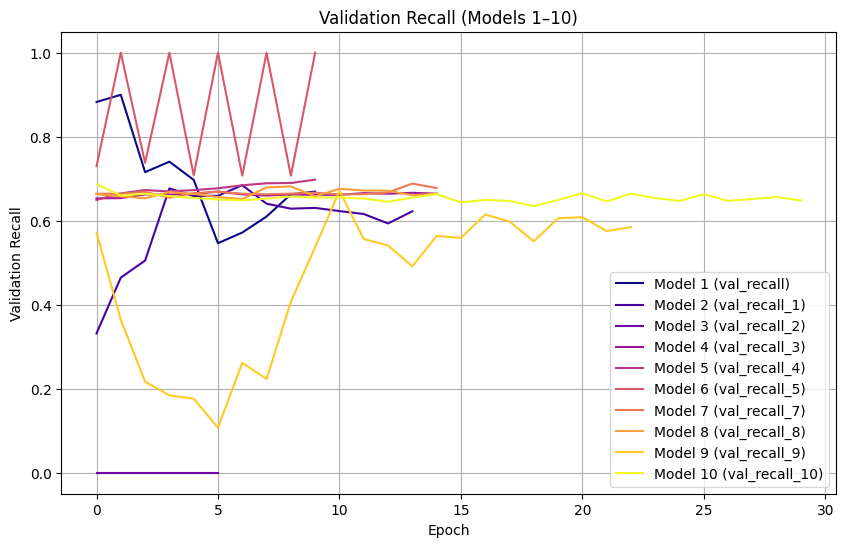

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List of records (1–10)
histories = [history_1, history_2, history_3, history_4, history_5,
             history_6, history_7, history_8, history_9, history_10]

colors = plt.cm.plasma(np.linspace(0, 1, len(histories)))

plt.figure(figsize=(10, 6))

for i, (hist, color) in enumerate(zip(histories, colors), start=1):
    # search for the key containing ‘val_recall’ (regardless of suffix)
    recall_keys = [k for k in hist.history.keys() if 'val_recall' in k]

    if recall_keys:
        key = recall_keys[0]  # we use the first match found
        plt.plot(hist.history[key], label=f'Model {i} ({key})', color=color)
    else:
        print(f"⚠️ No val_recall found in history_{i} (keys: {list(hist.history.keys())})")

plt.title('Validation Recall (Models 1–10)')
plt.xlabel('Epoch')
plt.ylabel('Validation Recall')
plt.legend()
plt.grid(True)
plt.show()










In [ ]:
# Plot validation precision for all 10 models across epochs.
# Each model’s precision curve is shown in a different color to compare consistency and improvement.
# Useful to analyze trade-offs between precision and recall during training.

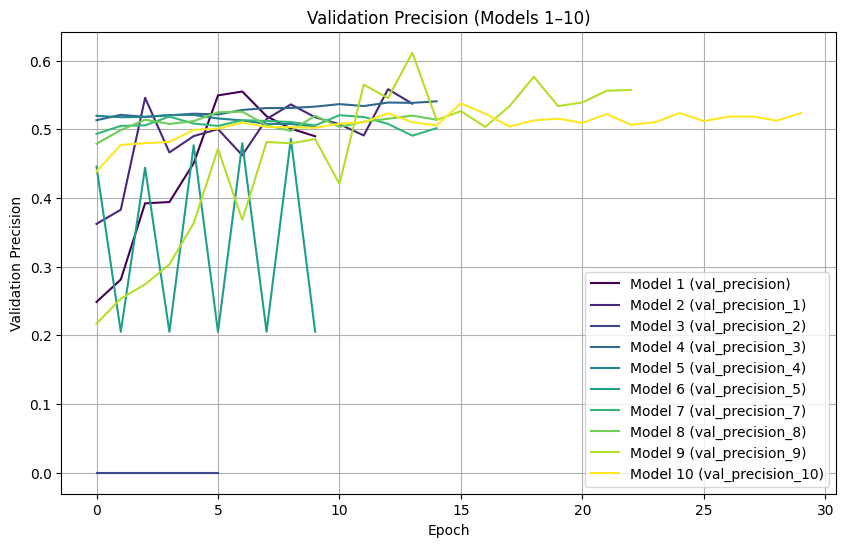

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List of your histories
histories = [history_1, history_2, history_3, history_4, history_5,
             history_6, history_7, history_8, history_9, history_10]

colors = plt.cm.viridis(np.linspace(0, 1, len(histories)))

plt.figure(figsize=(10, 6))

for i, (hist, color) in enumerate(zip(histories, colors), start=1):
    # Search for any key containing 'val_precision'
    precision_keys = [k for k in hist.history.keys() if 'val_precision' in k]

    if not precision_keys:
        print(f"⚠️ No val_precision found in history_{i} (keys: {list(hist.history.keys())})")
        continue

    key = precision_keys[0]
    plt.plot(hist.history[key], label=f'Model {i} ({key})', color=color)

plt.title('Validation Precision (Models 1–10)')
plt.xlabel('Epoch')
plt.ylabel('Validation Precision')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Compute and plot the validation F1-score across all 10 models using val_precision and val_recall.
# Each curve shows how F1 evolves per epoch, helping visualize which models achieved the best balance.
# Prints the best F1 and epoch per model, and highlights the top-performing model overall.

Model 1: max F1 = 0.5706 (epoch 8)
Model 2: max F1 = 0.5788 (epoch 8)
Model 3: max F1 = 0.0000 (epoch 0)
Model 4: max F1 = 0.5962 (epoch 14)
Model 5: max F1 = 0.5872 (epoch 4)
Model 6: max F1 = 0.5762 (epoch 8)
Model 7: max F1 = 0.5830 (epoch 10)
Model 8: max F1 = 0.5831 (epoch 12)
Model 9: max F1 = 0.5716 (epoch 20)
Model 10: max F1 = 0.5860 (epoch 15)


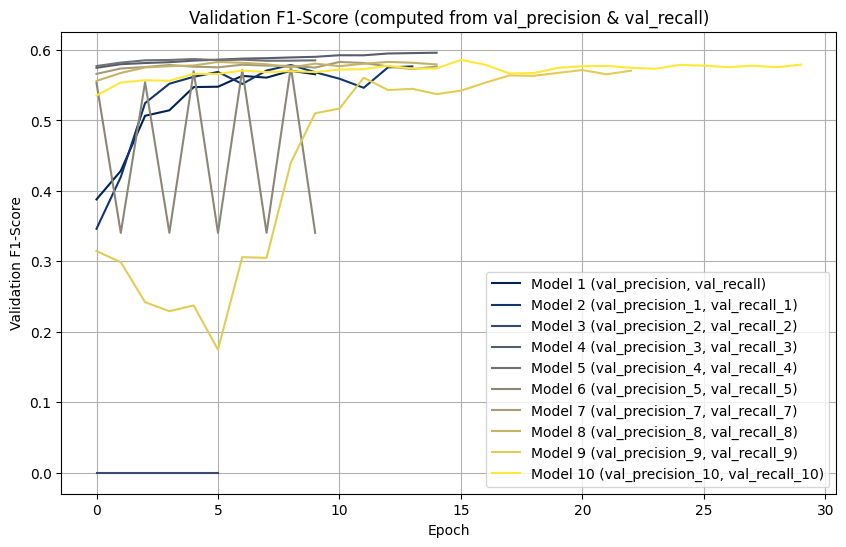


🏆 Best overall model:
Model 4 with F1 = 0.5962 at epoch 14


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List of records
histories = [history_1, history_2, history_3, history_4, history_5,
             history_6, history_7, history_8, history_9, history_10]

colors = plt.cm.cividis(np.linspace(0, 1, len(histories)))

plt.figure(figsize=(10, 6))

best_model = None
best_f1 = -1
best_epoch = -1

for i, (hist, color) in enumerate(zip(histories, colors), start=1):
    # Automatically search for the correct keys
    prec_keys = [k for k in hist.history.keys() if 'val_precision' in k]
    rec_keys = [k for k in hist.history.keys() if 'val_recall' in k]

    if prec_keys and rec_keys:
        val_prec = np.array(hist.history[prec_keys[0]])
        val_rec = np.array(hist.history[rec_keys[0]])
        val_f1 = 2 * (val_prec * val_rec) / (val_prec + val_rec + 1e-8)

        plt.plot(val_f1, label=f'Model {i} ({prec_keys[0]}, {rec_keys[0]})', color=color)

        # Best F1 for this model
        max_f1 = np.max(val_f1)
        epoch_best = np.argmax(val_f1)
        print(f"Model {i}: max F1 = {max_f1:.4f} (epoch {epoch_best})")

        # Update the best overall
        if max_f1 > best_f1:
            best_f1 = max_f1
            best_model = i
            best_epoch = epoch_best
    else:
        print(f"⚠️ Missing metrics for model {i}: precision or recall not found ({list(hist.history.keys())})")

plt.title('Validation F1-Score (computed from val_precision & val_recall)')
plt.xlabel('Epoch')
plt.ylabel('Validation F1-Score')
plt.legend()
plt.grid(True)
plt.show()

print("\n🏆 Best overall model:")
print(f"Model {best_model} with F1 = {best_f1:.4f} at epoch {best_epoch}")





In [ ]:
# Evaluate all 10 trained models on the test set using consistent features.
# Calculates precision, recall, F1-score, and AUC for each model, then identifies the best one by F1.
# Ensures feature alignment across models by adding missing columns and preserving original order.

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import joblib
import numpy as np

best_model_idx = None
best_f1 = -1

print("📊 TEST SET EVALUATION\n")

for i in range(1, 11):
    try:
        # 1️⃣ Load model and features
        model = load_model(f'model{i}.h5')
        features = joblib.load(f'features_model{i}.pkl')

        # 2️⃣ Adjust X_test to the model features
        X_test_adj = X_test.copy()

        # Add missing columns with 0 (if the dataset changed)
        for feat in features:
            if feat not in X_test_adj.columns:
                X_test_adj[feat] = 0

        # Rearrange the columns to their original order
        X_test_adj = X_test_adj[features]

        # 3️⃣ Predictions
        y_pred = model.predict(X_test_adj)
        y_pred_classes = (y_pred > 0.5).astype(int)

        # 4️⃣ Metrics
        precision = precision_score(y_test, y_pred_classes)
        recall = recall_score(y_test, y_pred_classes)
        f1 = f1_score(y_test, y_pred_classes)
        auc = roc_auc_score(y_test, y_pred)

        print(f"Model {i}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

        # 5️⃣ Save the best model for F1
        if f1 > best_f1:
            best_f1 = f1
            best_model_idx = i

    except Exception as e:
        print(f"⚠️ Error evaluating model {i}: {e}")

print("\n🏆 Best model on TEST set:")
print(f"Model {best_model_idx} with F1 = {best_f1:.4f}")


📊 TEST SET EVALUATION

133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Model 1: Precision=0.2061, Recall=1.0000, F1=0.3417, AUC=0.7878
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 2: Precision=0.0000, Recall=0.0000, F1=0.0000, AUC=0.7732


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 3: Precision=0.0000, Recall=0.0000, F1=0.0000, AUC=0.5000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 4: Precision=0.7602, Recall=0.1489, F1=0.2490, AUC=0.7862


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 5: Precision=0.7872, Recall=0.1271, F1=0.2189, AUC=0.7918


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 6: Precision=0.7578, Recall=0.1936, F1=0.3084, AUC=0.7809


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model 7: Precision=0.7602, Recall=0.1924, F1=0.3071, AUC=0.7924


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model 8: Precision=0.4863, Recall=0.6529, F1=0.5575, AUC=0.8143
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model 9: Precision=0.0000, Recall=0.0000, F1=0.0000, AUC=0.7745
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model 10: Precision=0.5090, Recall=0.6186, F1=0.5584, AUC=0.8116

🏆 Best model on TEST set:
Model 10 with F1 = 0.5584


In [ ]:
# Evaluate all 10 ANN models on the test set ensuring consistent feature alignment.
# For each model, missing columns are added and reordered to match the training setup.
# Computes Precision, Recall, F1, and AUC, stores results in a DataFrame, and identifies the best model by F1-score.

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import joblib
import numpy as np
import pandas as pd

best_model_idx = None
best_f1 = -1

print("📊 TEST SET EVALUATION (CONSISTENT FEATURES)\n")

results = []

for i in range(1, 11):
    try:
        print(f"\nEvaluating Model {i} ...")

        # 1️⃣ Load the model and columns used in training
        model = load_model(f'model{i}.h5')
        features = joblib.load(f'features_model{i}.pkl')

        # 2️⃣ Copy X_test and adapt it
        X_test_adj = X_test.copy()

        # Add missing columns with a neutral value (0)
        for f in features:
            if f not in X_test_adj.columns:
                X_test_adj[f] = 0

        # 3️⃣ Rearrange the columns to their original order
        X_test_adj = X_test_adj[features]


        # 5️⃣ Predictions
        y_pred = model.predict(X_test_adj)
        y_pred_classes = (y_pred > 0.5).astype(int)

        # 6️⃣ Metrics
        precision = precision_score(y_test, y_pred_classes, zero_division=0)
        recall = recall_score(y_test, y_pred_classes, zero_division=0)
        f1 = f1_score(y_test, y_pred_classes, zero_division=0)

        try:
            auc = roc_auc_score(y_test, y_pred)
        except:
            auc = np.nan

        results.append({
            "Model": i,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "AUC": auc
        })

        print(f"✅ Model {i} → Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

        # Save best model according to F1
        if f1 > best_f1:
            best_f1 = f1
            best_model_idx = i

    except Exception as e:
        print(f"⚠️ Error evaluating model {i}: {e}")

# Convert to DataFrame to see overview
results_df = pd.DataFrame(results).sort_values("F1", ascending=False)
print("\n🏁 FINAL SUMMARY (sorted by F1):")
print(results_df)

print(f"\n🏆 Best model: Model {best_model_idx} with F1={best_f1:.4f}")


📊 TEST SET EVALUATION (CONSISTENT FEATURES)


Evaluating Model 1 ...
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Model 1 → Precision=0.2061, Recall=1.0000, F1=0.3417, AUC=0.7878

Evaluating Model 2 ...


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
✅ Model 2 → Precision=0.0000, Recall=0.0000, F1=0.0000, AUC=0.7732

Evaluating Model 3 ...


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


✅ Model 3 → Precision=0.0000, Recall=0.0000, F1=0.0000, AUC=0.5000

Evaluating Model 4 ...
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Model 4 → Precision=0.7602, Recall=0.1489, F1=0.2490, AUC=0.7862

Evaluating Model 5 ...


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


✅ Model 5 → Precision=0.7872, Recall=0.1271, F1=0.2189, AUC=0.7918

Evaluating Model 6 ...
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Model 6 → Precision=0.7578, Recall=0.1936, F1=0.3084, AUC=0.7809

Evaluating Model 7 ...


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Model 7 → Precision=0.7602, Recall=0.1924, F1=0.3071, AUC=0.7924

Evaluating Model 8 ...


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


✅ Model 8 → Precision=0.4863, Recall=0.6529, F1=0.5575, AUC=0.8143

Evaluating Model 9 ...
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


✅ Model 9 → Precision=0.0000, Recall=0.0000, F1=0.0000, AUC=0.7745

Evaluating Model 10 ...
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Model 10 → Precision=0.5090, Recall=0.6186, F1=0.5584, AUC=0.8116

🏁 FINAL SUMMARY (sorted by F1):
   Model  Precision    Recall        F1       AUC
9     10   0.508954  0.618557  0.558428  0.811628
7      8   0.486348  0.652921  0.557457  0.814258
0      1   0.206091  1.000000  0.341750  0.787755
5      6   0.757848  0.193585  0.308394  0.780865
6      7   0.760181  0.192440  0.307130  0.792366
3      4   0.760234  0.148912  0.249042  0.786249
4      5   0.787234  0.127148  0.218935  0.791791
1      2   0.000000  0.000000  0.000000  0.773178
2      3   0.000000  0.000000  0.000000  0.500000
8      9   0.000000  0.000000  0.000000  0.774532

🏆 Best model: Model 10 with F1=0.5584


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import joblib
import numpy as np
import pandas as pd

best_model_idx = None
best_f1 = -1

print("📊 TEST SET EVALUATION (CONSISTENT FEATURES + THRESHOLD SWEEP)\n")

results = []

for i in range(1, 11):
    try:
        print(f"\nEvaluating Model {i} ...")

        # 1️⃣  Load template and its columns
        model = load_model(f'model{i}.h5')
        features = joblib.load(f'features_model{i}.pkl')

        # 2️⃣ Adapt X_test
        X_test_adj = X_test.copy()
        for f in features:
            if f not in X_test_adj.columns:
                X_test_adj[f] = 0
        X_test_adj = X_test_adj[features]

        # 3️⃣ Predictions (probabilities)
        y_pred = model.predict(X_test_adj)

        # Evaluate standard threshold (0.5)
        y_pred_classes = (y_pred > 0.5).astype(int)
        precision = precision_score(y_test, y_pred_classes, zero_division=0)
        recall = recall_score(y_test, y_pred_classes, zero_division=0)
        f1 = f1_score(y_test, y_pred_classes, zero_division=0)
        try:
            auc = roc_auc_score(y_test, y_pred)
        except:
            auc = np.nan

        print(f"   Default threshold (0.5): Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

        # 4️⃣ Find the optimal threshold for F1
        best_t, best_f1_local, best_recall, best_precision = 0.5, f1, recall, precision
        for t in [0.2, 0.3, 0.4, 0.5]:
            y_pred_classes = (y_pred > t).astype(int)
            p = precision_score(y_test, y_pred_classes, zero_division=0)
            r = recall_score(y_test, y_pred_classes, zero_division=0)
            f = f1_score(y_test, y_pred_classes, zero_division=0)
            if f > best_f1_local:
                best_t, best_f1_local, best_recall, best_precision = t, f, r, p
            print(f"      Threshold {t:.1f} → Precision={p:.3f}, Recall={r:.3f}, F1={f:.3f}")

        # 5️⃣ Save results
        results.append({
            "Model": i,
            "AUC": auc,
            "F1@0.5": f1,
            "Best_F1": best_f1_local,
            "Best_Threshold": best_t,
            "Precision@best": best_precision,
            "Recall@best": best_recall
        })

        print(f"   🔍 Best threshold for Model {i}: {best_t:.2f} → F1={best_f1_local:.4f}")

        # 6️⃣ Update better global model
        if best_f1_local > best_f1:
            best_f1 = best_f1_local
            best_model_idx = i

    except Exception as e:
        print(f"⚠️ Error evaluating model {i}: {e}")

# 7️⃣ Show summary sorted by best F1
results_df = pd.DataFrame(results).sort_values("Best_F1", ascending=False)
print("\n🏁 FINAL SUMMARY (sorted by best F1):")
print(results_df.to_string(index=False))

print(f"\n🏆 Best overall model: Model {best_model_idx} with F1={best_f1:.4f}")



📊 TEST SET EVALUATION (CONSISTENT FEATURES + THRESHOLD SWEEP)


Evaluating Model 1 ...
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
   Default threshold (0.5): Precision=0.2061, Recall=1.0000, F1=0.3417, AUC=0.7878
      Threshold 0.2 → Precision=0.206, Recall=1.000, F1=0.342
      Threshold 0.3 → Precision=0.206, Recall=1.000, F1=0.342
      Threshold 0.4 → Precision=0.206, Recall=1.000, F1=0.342
      Threshold 0.5 → Precision=0.206, Recall=1.000, F1=0.342
   🔍 Best threshold for Model 1: 0.50 → F1=0.3417

Evaluating Model 2 ...


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
   Default threshold (0.5): Precision=0.0000, Recall=0.0000, F1=0.0000, AUC=0.7732
      Threshold 0.2 → Precision=0.206, Recall=1.000, F1=0.342
      Threshold 0.3 → Precision=0.215, Recall=0.975, F1=0.352
      Threshold 0.4 → Precision=0.000, Recall=0.000, F1=0.000
      Threshold 0.5 → Precision=0.000, Recall=0.000, F1=0.000
   🔍 Best threshold for Model 2: 0.30 → F1=0.3522

Evaluating Model 3 ...


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


   Default threshold (0.5): Precision=0.0000, Recall=0.0000, F1=0.0000, AUC=0.5000
      Threshold 0.2 → Precision=0.206, Recall=1.000, F1=0.342
      Threshold 0.3 → Precision=0.206, Recall=1.000, F1=0.342
      Threshold 0.4 → Precision=0.206, Recall=1.000, F1=0.342
      Threshold 0.5 → Precision=0.000, Recall=0.000, F1=0.000
   🔍 Best threshold for Model 3: 0.20 → F1=0.3417

Evaluating Model 4 ...
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
   Default threshold (0.5): Precision=0.7602, Recall=0.1489, F1=0.2490, AUC=0.7862
      Threshold 0.2 → Precision=0.717, Recall=0.288, F1=0.410
      Threshold 0.3 → Precision=0.748, Recall=0.238, F1=0.361
      Threshold 0.4 → Precision=0.748, Recall=0.183, F1=0.294
      Threshold 0.5 → Precision=0.760, Recall=0.149, F1=0.249
   🔍 Best threshold for Model 4: 0.20 → F1=0.4105

Evaluating Model 5 ...


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
   Default threshold (0.5): Precision=0.7872, Recall=0.1271, F1=0.2189, AUC=0.7918
      Threshold 0.2 → Precision=0.747, Recall=0.244, F1=0.368
      Threshold 0.3 → Precision=0.754, Recall=0.194, F1=0.308
      Threshold 0.4 → Precision=0.772, Recall=0.163, F1=0.269
      Threshold 0.5 → Precision=0.787, Recall=0.127, F1=0.219
   🔍 Best threshold for Model 5: 0.20 → F1=0.3679

Evaluating Model 6 ...


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
   Default threshold (0.5): Precision=0.7578, Recall=0.1936, F1=0.3084, AUC=0.7809
      Threshold 0.2 → Precision=0.697, Recall=0.296, F1=0.415
      Threshold 0.3 → Precision=0.722, Recall=0.247, F1=0.369
      Threshold 0.4 → Precision=0.747, Recall=0.216, F1=0.336
      Threshold 0.5 → Precision=0.758, Recall=0.194, F1=0.308
   🔍 Best threshold for Model 6: 0.20 → F1=0.4151

Evaluating Model 7 ...


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
   Default threshold (0.5): Precision=0.7602, Recall=0.1924, F1=0.3071, AUC=0.7924
      Threshold 0.2 → Precision=0.682, Recall=0.320, F1=0.435
      Threshold 0.3 → Precision=0.738, Recall=0.277, F1=0.403


      Threshold 0.4 → Precision=0.745, Recall=0.234, F1=0.356
      Threshold 0.5 → Precision=0.760, Recall=0.192, F1=0.307
   🔍 Best threshold for Model 7: 0.20 → F1=0.4353

Evaluating Model 8 ...
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


   Default threshold (0.5): Precision=0.4863, Recall=0.6529, F1=0.5575, AUC=0.8143
      Threshold 0.2 → Precision=0.232, Recall=0.984, F1=0.376
      Threshold 0.3 → Precision=0.295, Recall=0.901, F1=0.444
      Threshold 0.4 → Precision=0.398, Recall=0.773, F1=0.526
      Threshold 0.5 → Precision=0.486, Recall=0.653, F1=0.557
   🔍 Best threshold for Model 8: 0.50 → F1=0.5575

Evaluating Model 9 ...
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


   Default threshold (0.5): Precision=0.0000, Recall=0.0000, F1=0.0000, AUC=0.7745
      Threshold 0.2 → Precision=0.206, Recall=1.000, F1=0.342
      Threshold 0.3 → Precision=0.206, Recall=1.000, F1=0.342
      Threshold 0.4 → Precision=0.000, Recall=0.000, F1=0.000
      Threshold 0.5 → Precision=0.000, Recall=0.000, F1=0.000
   🔍 Best threshold for Model 9: 0.20 → F1=0.3417

Evaluating Model 10 ...
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
   Default threshold (0.5): Precision=0.5090, Recall=0.6186, F1=0.5584, AUC=0.8116
      Threshold 0.2 → Precision=0.239, Recall=0.973, F1=0.384
      Threshold 0.3 → Precision=0.317, Recall=0.872, F1=0.465
      Threshold 0.4 → Precision=0.399, Recall=0.742, F1=0.519
      Threshold 0.5 → Precision=0.509, Recall=0.619, F1=0.558
   🔍 Best threshold for Model 10: 0.50 → F1=0.5584

🏁 FINAL SUMMARY (sorted by best F1):
 Model      AUC   F1@0.5  Best_F1  Best_Threshold  Precision@best  Recall@best
    10 0.811628 0.558428 0.558428             0.5     

In [ ]:
# Final Reflection – Robustness Checks and Results Interpretation in ANNs
#
# The objective of applying robustness checks in this Artificial Neural Network (ANN) setup was to assess the stability
# and consistency of the model under different experimental conditions, rather than evaluating its predictive ability
# for a specific future period. While time-series validation focuses on temporal generalization (for instance, predicting
# one year based on past seasons), robustness checks were chosen to evaluate the model’s reliability across different
# data configurations, such as changes in feature selection, scaling methods, balancing strategies, and temporal scope.
#
# This decision was made because, for CAICLE’s goal — identifying high-performing cyclists — the main challenge is not
# forecasting future races but detecting patterns of consistent performance across varying historical contexts.
# Robustness checks therefore allow testing whether the ANN can maintain similar predictive behavior when input
# conditions or data composition change, reflecting the variability seen in real-world racing data.
#
# The experiments revealed that the network was highly sensitive to preprocessing choices and dataset composition.
# Validation F1-scores remained stable between 0.57 and 0.60, suggesting that the models learned discriminative
# relationships within their own configurations. However, the test results exposed performance fluctuations, where
# only Models 8 and 10 achieved comparable scores (F1 ≈ 0.55), while others degraded significantly.
#
# This behavior does not indicate model failure — instead, it fulfills the goal of the robustness checks: to identify
# under which setups the ANN remains stable and under which it overfits or collapses. The fact that Models 8 and 10
# retained similar generalization ability indicates that these architectures and data setups were more resilient to
# distribution shifts.
#
# In conclusion, by using robustness checks, the team ensured that the ANN was evaluated not just on temporal
# generalization, but on structural robustness — determining how preprocessing, class balancing, and temporal composition
# influence the stability of predictions. This provided valuable insights into the fragility and strengths of the neural
# architecture, helping guide future iterations toward models capable of consistently identifying elite cyclists
# regardless of season or dataset variation.

